# Mask detection with TensorFlow

This notebook contains a simple implementation of a Deep Learning model for **real time object detection**. In this particular case, the object to be detected is a **mask**.

The model presented in this repository has been totally implemented using open source tools (i.e., Python 3 and TensorFlow 2), and is designed to be run on an a system with a NVIDIA graphics card with CUDA architectures (so we can take advantage of *tensorflow-gpu* to speed up the training).

I got idea to design this model after watching one of the YouTube videos by [Nicholas Renotte](https://www.youtube.com/watch?v=yqkISICHH-U). Some of the steps followed in this project, resemble what he has done for other use cases (e.g., sign object detection). I also used an amazing graphical image annotation package, *LabelImg*, developed by [Tzuta Lin](https://github.com/tzutalin/labelImg).


## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import pandas as pd
import cv2 
import uuid
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import requests
import tarfile
import json
from google.protobuf import text_format

# TensorFlow
import tensorflow as tf
from tensorflow import keras

### TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.1
The GPU will be used for calculations.


## Functions

In [3]:
def countdown(number):
    
    """
    Print countdown.
    
    Parameters:
    number (int): Number used for the countdown in seconds.
    """
    
    for i in range(number,0,-1):
        print('{}...'.format(i))
        time.sleep(1)

In [4]:
def take_pictures(list_classes, number_pictures, path_data_raw, number, device):
    
    """
    Take pictures from the webcam every X seconds and save the data locally.
    
    Parameters:
    list_classes (list): List of possible classes to be pictured.
    number_pictures (int): Number specifing the number of pictures per class to be taken.
    path_data_raw (Path): Path to the folder where the images must be saved.
    number (int): Number used for the countdown in seconds.
    device (string): Either the 'built-in' camera, or the 'external' one (useful for laptops).
    """
    
    # Define time before start
    start_gap = 5

    # Print info 
    print('\nWe will take pictures for {} classes: {}'.format(len(list_classes), list_classes))
    print('Will start in about {} seconds...'.format(start_gap))
    time.sleep(start_gap)
    
    # Iterate over each class
    for label in list_classes:
        
        # Print info
        print("\n - Let's take {} pictures for {}: \n".format(number_pictures, label))
        time.sleep(number)
        
        # Select camera
        if device == 'built-in':
            camera = cv2.VideoCapture(0)
        elif device == 'external':
            camera = cv2.VideoCapture(1)
        
        # Take the number of pictures specified
        for pic in range(1, number_pictures + 1):
            
            # Print countdown until picture
            countdown(number)
            
            # Take picture
            print('Photo {}! ({}) \n'.format(pic, label))
            _, image = camera.read()
            
            # Save image
            img_path = os.path.join(path_data_raw, label, '{}_{}.jpg'.format(label, pic))
            print(img_path)
            cv2.imwrite(img_path, image)
        
        # Wait before next class
        time.sleep(3)
    
    # Close camera
    camera.release()
    del(camera)
    cv2.destroyAllWindows()

In [5]:
def restart_directory(path):
    
    """
    Restart a directory:
        If it already exists, remove it and creates a new one.
        If it doesn't exist yet, create it.
    
    Parameters:
    path_data_raw (Path): Path to the folder to be restarted.
    """

    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.mkdir(path)

## Set up directories

In [6]:
# Set data paths
PATH_DATA = Path('data')
PATH_RAW_DATA = Path(os.path.join(PATH_DATA, 'raw'))
PATH_PROCESSED_DATA = Path(os.path.join(PATH_DATA, 'processed'))
PATH_RECORDS_DATA = Path(os.path.join(PATH_DATA, 'records'))

# Set model paths
PATH_PRE_TRAINED = Path('pre_trained_model')
PATH_MODEL = Path('model')

# Set secondary sub-folders
PATH_MASK = Path(os.path.join(PATH_RAW_DATA, 'Mask')) 
PATH_NO_MASK = Path(os.path.join(PATH_RAW_DATA, 'No-mask'))
TRAIN_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'train')) 
TEST_DATA = Path(os.path.join(PATH_PROCESSED_DATA, 'test'))
PATH_IMAGES = Path('img')

# Set path to Tensorflow folders
PATH_TENSORFLOW = Path('Tensorflow')
PATH_TENSORFLOW_RESEARCH = Path(os.path.join(PATH_TENSORFLOW, 'models', 'research'))
PATH_OBJECT_DETECTION = Path(os.path.join(PATH_TENSORFLOW_RESEARCH, 'object_detection'))
PATH_ANNOTATIONS = Path('annotations')

In [7]:
# Restart main folders
restart_directory(PATH_PROCESSED_DATA) 
restart_directory(PATH_RECORDS_DATA)
restart_directory(PATH_PRE_TRAINED)
restart_directory(PATH_ANNOTATIONS)
restart_directory(TRAIN_DATA) 
restart_directory(TEST_DATA)

## Import data

In this section, we will generate the training, validation and test sets, which will be composed of actual images taken by ourselves.

In [8]:
# Define classes
classes = ['Mask', 'No-mask']

In [9]:
# Specify if you want to refresh pictures
refresh_pictures = False
if refresh_pictures:
    
    # Remove previous stored pictures
    restart_directory(PATH_MASK) 
    restart_directory(PATH_NO_MASK)
    
    # Take 10 pictures for each class every 2 seconds and save them locally
    take_pictures(classes, 20, PATH_RAW_DATA, 2, 'external') # I use an external webcam

## Describe data

In [10]:
# Describe data size
for label in classes:
    
    # Get list of files in folder
    list_files = os.listdir(os.path.join(PATH_DATA, 'raw', label))

    # Avoid non-relevant elements in folders
    list_files = [pic for pic in list_files if pic.endswith('.jpg')]
    
    # Print number of pictures per folder
    num_files = len(list_files)
    print('Total {} images: {}'.format(label, num_files))

Total Mask images: 20
Total No-mask images: 20


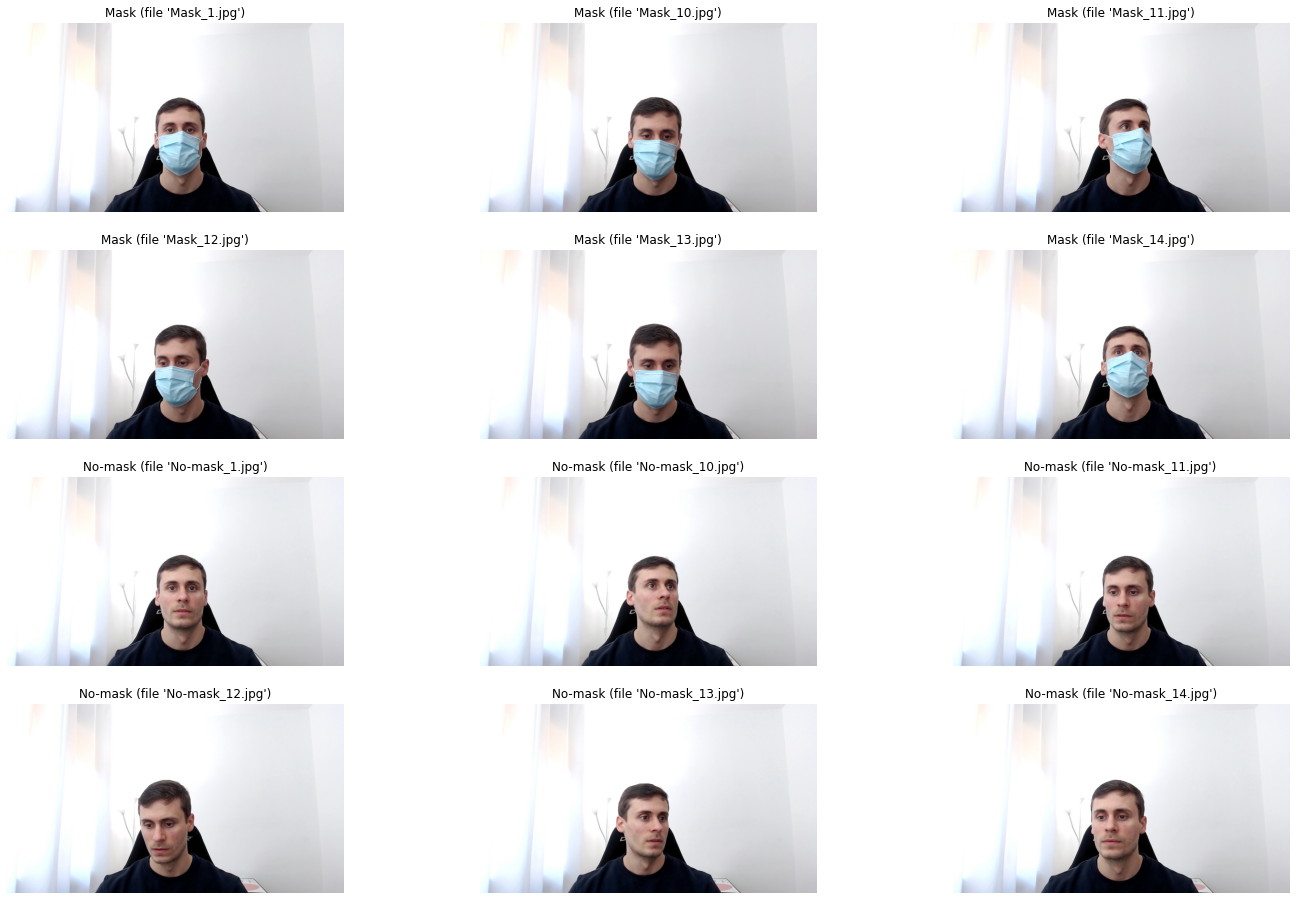

In [11]:
# Number of pictures in the grid
nrows = 4
ncols = 3

# Set up matplotlib fig
longitude_image = 8 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image / 2)

# List all files per folder
mask_files = os.listdir(PATH_MASK)
no_mask_files = os.listdir(PATH_NO_MASK)

# Remove non-relevant elements in folders
mask_files = [pic for pic in mask_files if pic.endswith('.jpg')]
no_mask_files = [pic for pic in no_mask_files if pic.endswith('.jpg')]

# Get paths to each file
list_mask_pix = [os.path.join(PATH_MASK, fname) for fname in mask_files]
list_no_mask_pix = [os.path.join(PATH_NO_MASK, fname) for fname in no_mask_files]

# Get each image
for i, img_path in enumerate(list_mask_pix[:(ncols*2)] + list_no_mask_pix[:(ncols*2)]):
    if '\\' in img_path: # Widnows format
        folder_name = img_path.split('\\')[2]
        picture_name = img_path.split('\\')[3]
    else: # Unix format
        folder_name = img_path.split('/')[2]
        picture_name = img_path.split('/')[3]
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("{} (file '{}')".format(folder_name, picture_name))

# Save image
plt.savefig(os.path.join(PATH_IMAGES, 'images.png'), dpi=150)

# Plot grid
plt.show()

## Label pictures

At this point, we have to label the images. For that purpose, let's use **[LabelImg](https://github.com/tzutalin/labelImg)**, a graphical image annotation tool. 

The process is the following:

**1. Clone the repo in your current directory**.

**2. Set up tool**.

**3. Label images**.

<br>

### Clone LabelImg repo

In [12]:
# Clone labelImg repository
if not os.path.exists('labelImg'):
    !git clone https://github.com/tzutalin/labelImg

### Set up the labelling tool

To run *make* you must have it installed already. If that's not the case:

- Follow these [instructions](https://stackoverflow.com/questions/32127524/how-to-install-and-use-make-in-windows) for Windows.
- Or these [instructions](https://formulae.brew.sh/formula/make) for macOS.

In [13]:
# Set up labelling tool
!cd labelImg && make qt5py3

pyrcc5 -o libs/resources.py resources.qrc


### Label images

In [14]:
# Label images
if refresh_pictures:
    !cd labelImg && python labelImg.py

![](img/screenshot_labelling.gif)

## Create train and test set

In [15]:
# Make a copy of the pictures files
list_mask_pix_jpg = list_mask_pix
list_no_mask_pix_jpg = list_no_mask_pix

In [16]:
# Get list of .jpg as well as .xml (i.e., boundary boxes)
list_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_mask_pix_jpg]
list_no_mask_pix_xml = [pic.replace('.jpg', '.xml') for pic in list_no_mask_pix_jpg]

# Sort list
list_mask_files = sorted(list_mask_pix_jpg + list_mask_pix_xml)
list_no_mask_files = sorted(list_no_mask_pix_jpg + list_no_mask_pix_xml)

In [17]:
# Use 20% of the instances as test set
split = round(len(list_mask_files)*0.8)

# Get training set
train_mask = list_mask_files[:split]
train_no_mask = list_no_mask_files[:split]

# Get test set
test_mask = list_mask_files[split:]
test_no_mask = list_no_mask_files[split:]

In [18]:
# Copy pictures to train/test folders
for pic in train_mask + train_no_mask:
    shutil.copy2(pic, TRAIN_DATA)
for pic in test_mask + test_no_mask:
    shutil.copy2(pic, TEST_DATA)

## Create label map

*TensorFlow* requires a label map to transform each label into an integer. 

In [19]:
# Create label dictionary
labels = [
    {'name':'Mask', 'id':1}, 
    {'name':'No-mask', 'id':2}
]

# Save as a new file
with open(os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt'), 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Install Object Detection API from TensorFlow 

The instructions to install the **Onject Detection API** have been obtained from this [link](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html).

In [20]:
# Clone TensorFlow models repository
if not os.path.exists(os.path.join(PATH_TENSORFLOW, 'models')):
    restart_directory(PATH_TENSORFLOW) 
    !cd ./Tensorflow && git clone https://github.com/tensorflow/models.git 

### Protobuf installation

Follow these [instructions](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#protobuf-installation-compilation) to install *Protobufs* for the Tensorflow Object Detection API.

### Compile Protobuf

In [21]:
# Compile protos
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=.

### Install COCO API 

In [22]:
# Clone COCO API repository
if not os.path.exists(os.path.join(PATH_TENSORFLOW, 'cocoapi')):
    restart_directory(os.path.join(PATH_TENSORFLOW, 'cocoapi'))
    !cd ./Tensorflow && pip install "git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI"

### Install the Object Detection API

In [23]:
# Copy setup script
shutil.copy2(os.path.join(PATH_OBJECT_DETECTION, 'packages', 'tf2', 'setup.py'), PATH_TENSORFLOW_RESEARCH);

In [24]:
# Install object_detection API 
# !cd Tensorflow/models/research && python -m pip install .

In [25]:
# Test that the Object Detection API is correctly installed (it takes around 2-3 minutes)
# !cd Tensorflow/models/research && python object_detection/builders/model_builder_tf2_test.py

## Generate TF records

Tensorflow needs the bounding box locations for every image in a specific format (i.e., as a *.TFRecord*).

In [26]:
# Download converter
if not os.path.exists('generate_tf_record.py'):
    url = 'https://tensorflow-object-detection-api-tutorial.readthedocs.io/'
    endpoint = 'en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py'
    response = requests.get(url + endpoint, stream=True)
    if response.status_code == 200:
        with open('generate_tfrecord.py', 'wb') as f:
            f.write(response.raw.read())

In [27]:
# Create train records
!python generate_tfrecord.py -x data/processed/train -l annotations/label_map.pbtxt -o data/records/train.record

# Create test records
!python generate_tfrecord.py -x data/processed/test -l annotations/label_map.pbtxt -o data/records/test.record

Successfully created the TFRecord file: data/records/train.record
Successfully created the TFRecord file: data/records/test.record


## Transfer learning 

### Download pre-trained models

Download the desired pre-trained model from the *TensorFlow* [repository](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). For this specific project, we will use the **ResNet50**.

In [28]:
# Select pre-trained model
model_name = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_path = model_name + '.tar.gz'

In [29]:
# Download pre-trained model
if not os.path.exists(os.path.join(PATH_PRE_TRAINED, model_name)):
    response = requests.get(model_url + model_path, stream=True)
    if response.status_code == 200:
        with open(model_path, 'wb') as f:
            f.write(response.raw.read())

    # Decompress file
    tar = tarfile.open(model_path)
    tar.extractall()
    tar.close()

    # Remove compressed file
    os.remove(model_path)
    
    # Move folder
    shutil.move(model_name, PATH_PRE_TRAINED);

### Configure training

In [30]:
# Import packages
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2

In [31]:
# Set config path
PATH_CONFIG = os.path.join(PATH_PRE_TRAINED, model_name, 'pipeline.config')
PATH_CONFIG_MOD = os.path.join(PATH_MODEL, 'pipeline.config')

In [32]:
# Specify if you want to retrain the model (around 5 hours in a GTX GPU)
retrain_model = False
if retrain_model:
    
    # Restart directory
    restart_directory(PATH_MODEL)
    
    # Define hyper-parameters
    batch_size = 4
    steps = 5000
    
    # Get config file
    config = pipeline_pb2.TrainEvalPipelineConfig()
    with tf.io.gfile.GFile(PATH_CONFIG, "r") as f:
        config_old = f.read()
        text_format.Merge(config_old, config)

    # Prepare a modified version of it
    config_new = open(PATH_CONFIG_MOD, "wt")

    # Update values
    config.model.ssd.num_classes = len(classes)
    config.train_config.batch_size = batch_size
    config.model.ssd.image_resizer.fixed_shape_resizer.height = 1080//2
    config.model.ssd.image_resizer.fixed_shape_resizer.width = 1920//2
    config.train_config.fine_tune_checkpoint = os.path.join(PATH_PRE_TRAINED, model_name, 'checkpoint', 'ckpt-0')
    config.train_config.fine_tune_checkpoint_type = 'detection'
    config.train_config.num_steps = steps
    config.train_config.use_bfloat16 = False
    config.train_input_reader.label_map_path = os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt')
    config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'train.record')]
    config.eval_input_reader[0].label_map_path = os.path.join(PATH_ANNOTATIONS, 'label_map.pbtxt')
    config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(PATH_RECORDS_DATA,'test.record')]

    # Save new file
    config_new = text_format.MessageToString(config)
    with tf.io.gfile.GFile(PATH_CONFIG_MOD, "wb") as f:
        f.write(config_new)

## Train model

In [33]:
# Copy executable script to run the model
if not os.path.exists('model_main_tf2.py'):
    shutil.copy2(os.path.join(PATH_OBJECT_DETECTION, 'model_main_tf2.py'), '.');

In [34]:
# Specify if you want to retrain the model (around 5 hours in a NVIDIA GeForce GTX 960M)
if retrain_model:
    !python model_main_tf2.py --model_dir=model/ --pipeline_config_path=model/pipeline.config 

2021-05-09 12:34:20.489756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-05-09 12:34:25.463117: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 12:34:25.465009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-05-09 12:34:26.268626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 74.65GiB/s
2021-05-09 12:34:26.268787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-05-09 12:34:26.279768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
2021-05-09 

### Monitor training with TensorBoard

In [ ]:
!tensorboard --logdir=model

**To open *TensorBoard***:

- Open port 6006: http://localhost:6006/

**To close *TensorBoard***:

- Just click the *Stop* button in the top-left of this Notebook.

This is an example of the information that you should be able to see:

![](img/tensorboard.png)

## Try your webcam!

The set up instructions for this section, were obtained from this TensorFlow [tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html).

In [ ]:
# Import modules
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('model/pipeline.config')
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

# Select highest 'ckpt' (i.e., latest checkpoint)
ckpt.restore(os.path.join('model', 'ckpt-6')).expect_partial() 

@tf.function
def detect_fn(image):
    """Detect objects in image"""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [ ]:
# Load labels
category_index = label_map_util.create_category_index_from_labelmap(
    os.path.join('annotations', 'label_map.pbtxt'), use_display_name=True
)

In [ ]:
# Select device: either the 'built-in' camera, or the 'external' one (useful for laptops).
device = 'built-in'

# Select camera
if device == 'built-in':
    cap = cv2.VideoCapture(0)
elif device == 'external':
    cap = cv2.VideoCapture(1)

In [ ]:
# Start video
while True:
    
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Convert image
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    # Visualise Real Team
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1920, 1080)))
    
    # Set rules to break
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# CLose camera
cap.release()
cv2.destroyAllWindows()


W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.moving_variance
W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.axis
W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.gamma
W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.beta
W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.moving_mean
W0509 12:35:14.010060 20044 util.py:160] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.moving_variance
W0509 12:35:14.011061 20044 util.py:160] Unre